__Resistive Wall for Arbitrary Layers (RWAL)__

D. W. Posthuma de Boer (ISIS, STFC, UKRI)

Code for computing the transverse driving impedance of an
infinitely long, multi-layer cylincrical strucutre. To run the
code, input settings in the settings section and then run
the whole notebook from start to finish. There are plots
for inspecting the impedance and wake, and output files are
saved in the outputs folder.

In [1]:
import os
import numpy as np
from numpy.lib import scimath as snp  # numpy sqrt(-1)
import matplotlib.pyplot as plt
import scipy.constants as cn
import sympy as ss
from sympy.utilities.lambdify import lambdify
import mpmath as mp
from tqdm import tqdm
from joblib import Parallel, delayed
import pyfilon as fil

rwal_version = "0.0.1"

solution_path = 'saved_solutions'
output_path = 'outputs'
nu = ss.symbols('nu')

# Settings

## File Save Settings

In [2]:
filename = 'thin_wall'

## MPMath Precision

Evaluation of the impedance involves some very large and very small floating
point numbers, so mpmath is used for several calculations. This setting defines
the precision used by mpmath. Setting it too high will slow down calculations,
setting it low could make results inaccurate.
See https://mpmath.org/doc/current/basics.html#setting-the-precision

In [3]:
mp.mp.dps = 25

## Frequency and Impedance Settings

The impedance will be evaluated at these frequencies 
and follow the chosen convention. If wakes are being
computed, then the sample frequencies should be dense
enough for the inverse Fourier transform.

In [4]:
freqs = np.logspace(0, 12, 1000)
impedance_convention = "-i" # "+j"

## Geometry Settings
`num_layers` defines the number of material layers, so that
1 = thick wall, 2 = thin wall etc.

`inner_radius` is the inner radius of the innermost material layer in metres.

`layer_thickness` is the layer thickness in metres. The outermost layer extends to infinity, so the thickness of that layer cannot be specified. The length of the array is therefore one less than the number of layers.

In [5]:
num_layers = 2

inner_radius = 50e-3

layer_thickness = [
    5e-3
]  # length should be num_layers - 1 (last layer extends to infty)


## Material Properties

Conductivity in Siemens/ metre. Permeability and permittivity are in SI units.

For lossy materials, the permeability and permittivity can be specified
as complex. The time-frequency FT's have been defined with engineering
convention, so that for example a lossy ferrite would have
$$
\mu = \mu' - i\mu'',
$$
where the imaginary part of $\mu$ is negative ($\mu''$ is positive).
This is also true for the permittivity. These conventions are
as defined in textbooks such as D. Pozars, "Introduction to
Microwave Engineering". 

For frequency dependent properties, quantities can be specified as
functions of the frequency variable, `nu`.

The last layer of conductivity can be specified as 'PEC' which
will create a perfectly conducting outer layer or 'PMC', which
will create a perfect magnetic conductor in the outermost layer.
Permeability and permittivity should be specified for PEC and PMC regions
(just to have the right length arrays).

In [6]:
conductivity = [
    1.4e6,
    0.0
]

permeability = [
    cn.mu_0,
    cn.mu_0
]

permittivity = [
    cn.epsilon_0,
    cn.epsilon_0
]

## Beam Settings

In [7]:
beta = 0.999
particle_offset = 1e-3  # For transverse impedance, anything smaller than inner radius

# multipole_moment is a variable, but a lot of RWAL
# assumes it is equal to 1. I've left it here for possible
# future developments, but it shouldn't ordinarily be changed.
multipole_moment = 1  # 0=monopole, 1=dipole, 2=quadrupole etc

## Space-Charge Options

In [8]:
include_direct_space_charge = False  # if true space charge impedance included
include_indirect_space_charge = False  # if true space charge impedance included

## Wake Function Options

---

**WARNING**

The wake computation of RWAL works in principle, but it is not automatically
accurate. The user has to get all the settings right and check convergence. 

---

In [9]:
# The variable wake_z contains the values of z (distance
# behind source particle) where the wake function is evaluated.
# z is defined as positive ahead of the source particle, so
# for a β = 1 beam, the wake will only be non-zero for z < 0.

compute_wake = True

# Mesh setting is used to control how many points
# are used for in the filon integration. Since the number of points
# must be an odd integer, the actual number of points
# used is (2 * mesh_setting + 1).
# Mesh setting must be a positive integer. A higher number
# can be better, but only frequency steps are sufficiently small
# for a linear interpolation to be accurate.
mesh_setting = 1

# Distance ahead of the source particle to calculate.
# Negative values are behind the source particle.
_z = -np.logspace(-4, 6, 500)
z = np.append(_z[::-1], -_z)

## Save Settings to File

In [10]:
settings_dict = {
    "rwal_version": rwal_version,
    "impedance_convention" : impedance_convention,
    "num_layers" : num_layers,
    "inner_radius" : inner_radius,
    "layer_thickness" : layer_thickness,
    "conductivity" : conductivity,
    "permeability" : permeability,
    "permittivity" : permittivity,
    "beta" : beta,
    "particle_offset": particle_offset,
    "multipole_moment": multipole_moment,
    "include_direct_space_charge": include_direct_space_charge,
    "include_indirect_space_charge": include_indirect_space_charge,
    "compute_wake": compute_wake,
    "frequency": freqs,
    "z": z
}

In [11]:
with open(os.path.join(output_path, filename + '.settings.txt'), 'w') as f:
    print(settings_dict, file=f)

# Build Matrices

For a scenario with `num_layers` material layers, there are a total of
`num_layers + 2` regions to solve for, which includes the vacuum region
inside and outside the radius of the source particle. 
The Fourier transforms of the longitudinal fields in region $n$ have the
general forms
$$
\begin{aligned}
\tilde{E}_{s, n}\left(r, \phi, s, \omega \right)
&=
\sum_{m=0}^{\infty}
\left[
A'_n I_{m} \left( \chi_n r \right) +
B'_n K_{m} \left( \chi_n r \right)
\right]
\left[
A''_n \cos(m \phi) + 
B''_n \sin(m \phi)
\right] e^{i\omega \frac{s}{v}},\\
\tilde{H}_{s, n}\left(r, \phi, s, \omega \right)
&=
\sum_{m=0}^{\infty}
\left[
D'_n I_{m} \left( \chi_n r \right) +
F'_n K_{m} \left( \chi_n r \right)
\right]
\left[
D''_n \cos(m \phi) + 
F''_n \sin(m \phi)
\right] e^{i\omega \frac{s}{v}},
\end{aligned}
$$

Each region has four unknown coefficients so there are a total of 
`4(num_layers + 2)` unknowns. We can apply matching conditions at
the interfaces between the regions, but there is one fewer boundary
than there are regions, so if we match four field components
($\tilde{E}_{s} \tilde{E}_{\phi} \tilde{H}_{s}$ and
$\tilde{H}_{\phi}$) at each boundary, then there are not enough
equations to solve the problem.

It is noticed that the innermost beam region actually only has two
unknowns since the coefficient of
$K_m(\chi_0 r)$ must be zero at $r=0$. The outermost region also
has only two unknowns since the coefficient of $I_m(\chi_N r)$
must be zero as $r \rightarrow \infty$. This reduces the number
of unknowns to `4(num_layers + 1)`, making the problem solvable.

Cramer's rule will be used to find an expression for the impedance, so 
matching conditions will be written down and a coefficient matrix constructed. 

In [12]:
num_regions = num_layers + 2  # inside beam, outside beam
num_boundaries = num_regions - 1

# Matching coefficients for I and K bessel functions
a = ss.symbols('a:{}'.format(num_regions)) 
b = ss.symbols('b:{}'.format(num_regions))
d = ss.symbols('d:{}'.format(num_regions))
f = ss.symbols('f:{}'.format(num_regions))

# Radii for the different layers
alpha = ss.symbols('alpha:{}'.format(num_regions-1))

# Permittivity and permeability
# permittivity should be complex E + i sigma/omega
# sigma = conductivity
epsilon = ss.symbols('epsilon:{}'.format(num_regions))
mu = ss.symbols('mu:{}'.format(num_regions))
sigma = ss.symbols('sigma:{}'.format(num_regions))

# Phase velocity and propagation constants
k = ss.symbols('k')
chi = ss.symbols('chi:{}'.format(num_regions))

# Angular frequency and frequency
omega = ss.symbols('omega')
#nu = ss.symbols('nu')

# Relativistic factors
v, gamma = ss.symbols('v gamma')

# A constant
Gamma = ss.symbols('Gamma')

# Multipole moment qe**m
Qm = ss.symbols('Q_m')

# moment integer
m = ss.symbols('m', integer=True)

# generic symbol
x = ss.symbols('x')

# delta_{m,0} = 1 of m=0 and 0 otherwise
dm = ss.symbols('\delta_{m0}')

In [13]:
def Ibp(m, argument):    
    return ss.diff(ss.besseli(m, x), x).subs({x: argument})

def Kbp(m, argument):    
    return ss.diff(ss.besselk(m, x), x).subs({x: argument})

def Kb(m, argument):
    return ss.besselk(m, argument)

def Ib(m, argument):
    return ss.besseli(m, argument)

## Generate Initial Matrix with Dimensions

Since the majority of elements in the matrix will be $0$, I will start by generating a
matrix with `zeros()` and then modify the non-zero elements.

In [14]:
matrix_size = 4 * num_boundaries

coef_matrix = ss.zeros(matrix_size)
# coef_matrix

## Populate Matrix Elements


In [15]:
# looping through the boundaries and connecting regions i and i+1,
# where i is the boundary number. The comments indicate which matching
# condition produced the coefficients for the matrix element.

for i in range(num_boundaries):
    if i == 0:
        # The boundary at the interface of the charge ring differs from all
        # subsequent boundaries, because there is no b[0] term in the innermost
        # region since Kb would go to infinity at r=0
        
        # Ez at r=a
        coef_matrix[0, 0] = -Ib(m, chi[i]*alpha[i])    # a0
        coef_matrix[0, 2] = Ib(m, chi[i+1]*alpha[i]) # a1
        coef_matrix[0, 3] = Kb(m, chi[i+1]*alpha[i]) # b1
        
        # Ephi at r=a
        coef_matrix[1, 5] = 1  # f1
        
        # Bz at r=a, don't need Hz since both sides vacuum
        coef_matrix[2, 1] = -Ib(m, chi[i]*alpha[i])    # d0
        coef_matrix[2, 4] = Ib(m, chi[i+1]*alpha[i]) # d1
        coef_matrix[2, 5] = Kb(m, chi[i+1]*alpha[i]) # f1
        
        # BPhi at r=a
        coef_matrix[3, 3] = 1
    
    elif i == num_boundaries - 1:
        # On the last iteration
        # of this loop i = (num_boundaries-1) = (num_regions-2)
        # This region does not have an a or d coefficients
        
        # Ez
        coef_matrix[i*4 + 0, (i-1)*4 + 2 + 0] = -Ib(m, chi[i]*alpha[i])  # a[i]
        coef_matrix[i*4 + 0, (i-1)*4 + 2 + 1] = -Kb(m, chi[i]*alpha[i])  # b[i]
        coef_matrix[i*4 + 0, (i-0)*4 + 2 + 0] = Kb(m, chi[i+1]*alpha[i])    # b[i+1] (there is no a[i+1])
        
        # EPhi
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 0] = (k*m/(chi[i]**2*alpha[i])) * Ib(m, chi[i]*alpha[i])  # a[i]
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 1] = (k*m/(chi[i]**2*alpha[i])) * Kb(m, chi[i]*alpha[i])  # b[i]
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 2] = (omega*mu[i]/chi[i])*Ibp(m, chi[i]*alpha[i])  # d[i]
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 3] = (omega*mu[i]/chi[i])*Kbp(m, chi[i]*alpha[i])  # f[i]
        coef_matrix[i*4 + 1, (i-0)*4 + 2 + 0] = -(k*m/(chi[i+1]**2*alpha[i])) * Kb(m, chi[i+1]*alpha[i])  # b[i+1] there is no a[i+1]
        coef_matrix[i*4 + 1, (i-0)*4 + 2 + 1] = -(omega*mu[i+1]/chi[i+1])*Kbp(m, chi[i+1]*alpha[i])  # f[i+1] there is no d[i+1]
        
        # Hz
        coef_matrix[i*4 + 2, (i-1)*4 + 2 + 2] = -Ib(m, chi[i]*alpha[i])  # d[i]
        coef_matrix[i*4 + 2, (i-1)*4 + 2 + 3] = -Kb(m, chi[i]*alpha[i])  # f[i]
        coef_matrix[i*4 + 2, (i-0)*4 + 2 + 1] = Kb(m, chi[i+1]*alpha[i])    # f[i+1] (there is no d[i+1])
        
        # HPhi
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 0] = -(omega*epsilon[i]/chi[i])*Ibp(m, chi[i]*alpha[i])  # a[i]
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 1] = -(omega*epsilon[i]/chi[i])*Kbp(m, chi[i]*alpha[i])  # b[i]
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 2] = -(k*m/(chi[i]**2*alpha[i]))*Ib(m, chi[i]*alpha[i])  # d[i]
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 3] = -(k*m/(chi[i]**2*alpha[i]))*Kb(m, chi[i]*alpha[i])  # f[i]
        coef_matrix[i*4 + 3, (i-0)*4 + 2 + 0] = (omega*epsilon[i+1]/chi[i+1])*Kbp(m, chi[i+1]*alpha[i])  # b[i+1]
        coef_matrix[i*4 + 3, (i-0)*4 + 2 + 1] = (k*m/(chi[i+1]**2*alpha[i]))*Kb(m, chi[i+1]*alpha[i])  # f[i+1]
    
    else:
        # Ez
        coef_matrix[i*4 + 0, (i-1)*4 + 2 + 0] = -Ib(m, chi[i]*alpha[i])  # a[i]
        coef_matrix[i*4 + 0, (i-1)*4 + 2 + 1] = -Kb(m, chi[i]*alpha[i])  # b[i]
        coef_matrix[i*4 + 0, (i-0)*4 + 2 + 0] = Ib(m, chi[i+1]*alpha[i])    # a[i+1]
        coef_matrix[i*4 + 0, (i-0)*4 + 2 + 1] = Kb(m, chi[i+1]*alpha[i])    # b[i+1]
        
        
        # EPhi
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 0] = (k*m/(chi[i]**2*alpha[i])) * Ib(m, chi[i]*alpha[i])  # a[i]
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 1] = (k*m/(chi[i]**2*alpha[i])) * Kb(m, chi[i]*alpha[i])  # b[i]
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 2] = (omega*mu[i]/chi[i])*Ibp(m, chi[i]*alpha[i])  # d[i]
        coef_matrix[i*4 + 1, (i-1)*4 + 2 + 3] = (omega*mu[i]/chi[i])*Kbp(m, chi[i]*alpha[i])  # f[i]
        coef_matrix[i*4 + 1, (i-0)*4 + 2 + 0] = -(k*m/(chi[i+1]**2*alpha[i])) * Ib(m, chi[i+1]*alpha[i])  # a[i+1]
        coef_matrix[i*4 + 1, (i-0)*4 + 2 + 1] = -(k*m/(chi[i+1]**2*alpha[i])) * Kb(m, chi[i+1]*alpha[i])  # b[i+1]
        coef_matrix[i*4 + 1, (i-0)*4 + 2 + 2] = -(omega*mu[i+1]/chi[i+1])*Ibp(m, chi[i+1]*alpha[i])  # d[i + 1]
        coef_matrix[i*4 + 1, (i-0)*4 + 2 + 3] = -(omega*mu[i+1]/chi[i+1])*Kbp(m, chi[i+1]*alpha[i])  # f[i + 1]
        
        # Hz
        coef_matrix[i*4 + 2, (i-1)*4 + 2 + 2] = -Ib(m, chi[i]*alpha[i])  # d[i]
        coef_matrix[i*4 + 2, (i-1)*4 + 2 + 3] = -Kb(m, chi[i]*alpha[i])  # f[i]
        coef_matrix[i*4 + 2, (i-0)*4 + 2 + 2] = Ib(m, chi[i+1]*alpha[i])    # d[i+1]
        coef_matrix[i*4 + 2, (i-0)*4 + 2 + 3] = Kb(m, chi[i+1]*alpha[i])    # f[i+1]
        
        # HPhi
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 0] = -(omega*epsilon[i]/chi[i])*Ibp(m, chi[i]*alpha[i])  # a[i]
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 1] = -(omega*epsilon[i]/chi[i])*Kbp(m, chi[i]*alpha[i])  # b[i]
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 2] = -(k*m/(chi[i]**2*alpha[i]))*Ib(m, chi[i]*alpha[i])  # d[i]
        coef_matrix[i*4 + 3, (i-1)*4 + 2 + 3] = -(k*m/(chi[i]**2*alpha[i]))*Kb(m, chi[i]*alpha[i])  # f[i]
        coef_matrix[i*4 + 3, (i-0)*4 + 2 + 0] = (omega*epsilon[i+1]/chi[i+1])*Ibp(m, chi[i+1]*alpha[i])  # a[i+1]
        coef_matrix[i*4 + 3, (i-0)*4 + 2 + 1] = (omega*epsilon[i+1]/chi[i+1])*Kbp(m, chi[i+1]*alpha[i])  # b[i+1]
        coef_matrix[i*4 + 3, (i-0)*4 + 2 + 2] = (k*m/(chi[i+1]**2*alpha[i]))*Ib(m, chi[i+1]*alpha[i])  # d[i+1]
        coef_matrix[i*4 + 3, (i-0)*4 + 2 + 3] = (k*m/(chi[i+1]**2*alpha[i]))*Kb(m, chi[i+1]*alpha[i])  # f[i+1]

# coef_matrix

## Generate Constant Matrix
We only need to find the coefficient $A_0$ so we require only one additional matrix.
The first column has been used for coefficients of $A_0$, and so will be replaced
with the constants from these matching equations. The only non-zero constant is from
the innermost boundary where the beam is considered to be a surface current which
produces a discontinuity in $B_{\phi}$. This constant will just be given the variable
$\Gamma$ and substituted later.

In [16]:
# Make an empty NxN matrix based on the num layers variable
const_matrix = coef_matrix.copy()

# The first columns is a_1 (or a[0] in sympy) so we replace that col with
# the constants col. Gamma comes from b2 and will be substituted later.
temp_matrix = ss.zeros(matrix_size, 1)  # make a matrix of the right size
temp_matrix[3] = Gamma
const_matrix[:, 0] = temp_matrix.copy()
del(temp_matrix)
# const_matrix

## Update Matrix for PEC and PMC Regions

In [17]:
# If the final region is PEC then don't solve in the outermost region.
# Number of unknowns decreases by 2. Last four matching conditions lost.
# Require two new boundary conditions. Set Ephi=Ez=0 at boundary.
# This is achieved by removing the matching conditions for Hz and HPhi and
# the last two columns which had coefficients of unknowns in outer region.
if conductivity[-1] == 'PEC':
    coef_matrix.row_del(-1)
    coef_matrix.row_del(-1)
    coef_matrix.col_del(-1)
    coef_matrix.col_del(-1)
    const_matrix.row_del(-1)
    const_matrix.row_del(-1)
    const_matrix.col_del(-1)
    const_matrix.col_del(-1)
    solution_path = os.path.join(solution_path, 'PEC')

# If the final region is PMC then don't solve in the outer most region.
# Set Hz = Hphi = 0 at boundary.
# This is achieved by removing the matching conditions for Ez and EPhi and
# the last two columns which had coefficients for unknowns in outer region.
elif conductivity[-1] == 'PMC':
    coef_matrix.row_del(-3)
    coef_matrix.row_del(-3)
    coef_matrix.col_del(-1)
    coef_matrix.col_del(-1)
    const_matrix.row_del(-3)
    const_matrix.row_del(-3)
    const_matrix.col_del(-1)
    const_matrix.col_del(-1)
    solution_path = os.path.join(solution_path, 'PMC')


# Find or Load Expressions

Before finding the expression, check whether this matrix hasn't
been solved before. If so, load the expressions rather than finding
them again.

In [18]:
def check_solution_path(path):
    if (os.path.exists(os.path.join(path, f'redu_n{num_layers}_z1perp.txt')) and
        os.path.exists(os.path.join(path, f'repl_n{num_layers}_z1perp.txt'))):
        return True
    
    return False


def save_cse(redu, repl, path):
    with open(os.path.join(path, f'redu_n{num_layers}_z1perp.txt'), 'w') as f:
        print(redu[0], file=f)

    with open(os.path.join(path, f'repl_n{num_layers}_z1perp.txt'), 'w') as f:
        for i in repl:
            print(i, file=f)
            
    
def load_cse(path):
    # For some reason the symbol m doesn't get converted into a symbol
    # by sympify, so I've had to specify this explicitly.
    ns = {}
    ns["m"] = m

    if check_solution_path(path):
        with open(os.path.join(path, f'redu_n{num_layers}_z1perp.txt')) as f:
            redu = [ss.sympify(f.readline(), locals = ns)]

        repl = []
        with open(os.path.join(path, f'repl_n{num_layers}_z1perp.txt'), 'r') as f:
            for line in f:
                repl.append(ss.sympify(line.strip(), locals = ns))
            
        return redu, repl
    
    else:
        print("Solution files not found")
        return 0, 0

In [19]:
if check_solution_path(solution_path):
    print("Loading pre-computed solution")
    redu, repl = load_cse(solution_path)

else:
    print("Finding new solution. May take some time.")
    
    # Find the field coefficient in inner region
    a1 = ss.simplify(const_matrix).det(method='lu')/ss.simplify(coef_matrix).det(method='lu')
    
    # Find the total transverse impedance (this includes space charge)
    Ztott = -1/(k*ss.pi*alpha[0]*Qm) * a1 * Ib(m, chi[0]*alpha[0]) * ss.pi
    
    # Perform CSE operation to simplify evaluation of impedance
    repl, redu = ss.simplify(ss.cse(Ztott))
    
    # Save solution for future use
    save_cse(redu, repl, solution_path)

Loading pre-computed solution


In [20]:
# Not used

# Zlong = -1/((cn.e)*pi*alpha[0]) * a1 * Ib(m, chi[0]*alpha[0]) * pi

# Substitute Settings

We're ready to start substituting numbers, which can be time-consuming due to the
potentially large expression for the impedance. To speed up computation
the CSE method will be used along with many lambdified functions. First a substitution
dictionary will be built up. This will substitute all the relevant symbols so that
the expression can be written in terms of the user defined settings.

## Build Substitution Dictionary

In [21]:
subs_dict = {}

# Constant from b2 and multipole moments
subs_dict[Gamma] = ss.I * omega * Qm / (epsilon[0]*v**2*gamma**2*ss.pi*alpha[0]**m * (1+dm))*Ib(m, chi[0]*alpha[0])
subs_dict[Qm] = cn.e * alpha[0]**m
subs_dict[m] = multipole_moment

# This is the value for Kronecker delta
if multipole_moment == 0:
    subs_dict[dm] = 1
else:
    subs_dict[dm] = 0
    
# Propagation Constants
subs_dict[chi[0]] = omega/v/gamma
subs_dict[chi[1]] = omega/v/gamma

for i in range(num_layers):
    subs_dict[chi[i+2]] = ss.sqrt(k**2 - omega**2*epsilon[i+2]*mu[i+2])

subs_dict[k] = omega/v


# Permeability
subs_dict[mu[0]] = cn.mu_0
subs_dict[mu[1]] = cn.mu_0
for n,i in enumerate(permeability):
    subs_dict[mu[n+2]] = i

# Permittivity
subs_dict[epsilon[0]] = cn.epsilon_0
subs_dict[epsilon[1]] = cn.epsilon_0
for n,i in enumerate(permittivity):
    subs_dict[epsilon[n+2]] = i - ss.I*sigma[n+2]/omega

# Conductivity
subs_dict[sigma[0]] = 0
subs_dict[sigma[1]] = 0
for n, i in enumerate(conductivity):
    subs_dict[sigma[n+2]] = i

    
# Relativity
subs_dict[gamma] = 1/ss.sqrt(1-v**2/cn.c**2)
subs_dict[v] = beta * cn.c

# Angular frequency
subs_dict[omega] = 2*ss.pi*nu


# Radii 
subs_dict[alpha[0]] = particle_offset
subs_dict[alpha[1]] = inner_radius

if len(alpha) > 2:
    total_rad = inner_radius
    for n, i in enumerate(layer_thickness):
        subs_dict[alpha[n+2]] = total_rad + i
        total_rad += i

## Perform substitution

In [22]:
def kvv(m, argument):
    return mp.besselk(m, argument)

def ivv(m, argument):
    return mp.besseli(m, argument)

bessel = {'besselk':kvv,'besseli':ivv}
libraries = [{'sqrt': snp.sqrt}, bessel, "numpy"]

In [23]:
# Substitute the dictionary into repl_subs.
# The only original variable which should be left is nu (frequency)
repl_subs = [(i[0], i[1].subs(subs_dict)) for i in repl]
redu_subs = [i.subs(subs_dict) for i in redu]

# Build an array for all of the numerical values of the repl variables
used_symbols = [nu]

repl_funs = []
for i, vv in enumerate(repl_subs):
    repl_funs.append(lambdify(used_symbols, vv[1], modules=libraries))
    used_symbols.append(vv[0])

# Lambdify the reduced method, using nu + all the CSE repl variables (x0, x1, x2, ...)
glam = lambdify(used_symbols, redu_subs[0], modules=libraries)

# Transverse Impedance

## Compute Transverse Impedance

In [24]:
def zperp_total(frequency):
    xs=[frequency]

    # Calculate numerical values for all of the repl_variables with
    # their respective functions (x0, x1, x2, ...)
    for fun in repl_funs:
        xs.append(fun(*xs))

    # Substitute all of the calculated numerical values into the lambdified
    # reduced function
    return glam(*xs)

res = [zperp_total(i) for i in tqdm(freqs)]

# At this point we've calculated all the impedances, but direct & indirect
# space-charge impedances still included.
# Also, all the elements of res are mpc objects (from mpmath). I won't convert
# them to ordinary floats until we've dealt with space charge.
res[0:5]

100%|██████████| 1000/1000 [00:12<00:00, 80.57it/s]


[mpc(real='31.5531259111565924945456872', imag='-95969.64197094621650158388087'),
 mpc(real='32.43802123029628794847130458', imag='-95969.64449195886139925723423'),
 mpc(real='33.34773288636333953985953139', imag='-95969.64715635323402739496766'),
 mpc(real='34.28295681959397343055337689', imag='-95969.64997228724592098015182'),
 mpc(real='35.24440848532267824409637143', imag='-95969.65294838261155504768876')]

## Subtract Space Charge Components

In [25]:
# Create formula for space-charge impedance and evaluate it.

# Write the formulas for direct and indirect space-charge
direct_space_charge = -ss.I*Ib(m, chi[0]*alpha[0])**2 / (ss.pi * alpha[0]**(m+1)*epsilon[0]*v*gamma**2) * (Kb(m, chi[0]*alpha[0])/Ib(m, chi[0]*alpha[0]))
indirect_space_charge = -ss.I*Ib(m, chi[0]*alpha[0])**2 / (ss.pi * alpha[0]**(m+1)*epsilon[0]*v*gamma**2) * -(Kb(m, chi[1]*alpha[1])/Ib(m, chi[1]*alpha[1]))
# space_charge = direct_space_charge + indirect_space_charge

# Lambidfy the space charge functions.
lambdified_direct_space_charge = lambdify(nu, direct_space_charge.subs(subs_dict), modules=libraries)
lambdified_indirect_space_charge = lambdify(nu, indirect_space_charge.subs(subs_dict), modules=libraries)

# This is only a short expression, so we can afford to evaluate it as many times as we need to.
direct_space_charge_res = [lambdified_direct_space_charge(i) for i in freqs]
indirect_space_charge_res = [lambdified_indirect_space_charge(i) for i in freqs]

In [26]:
# Subtract space-charge if that is requested.

results = np.array([float(i.real) + 1j*float(i.imag) for i in res], dtype=np.complex128)

if include_direct_space_charge is False:
    results = np.array([float(i.real - j.real) + 1j*float(i.imag - j.imag) for i,j in zip(results, direct_space_charge_res)])

if include_indirect_space_charge is False:
    results = np.array([float(i.real - j.real) + 1j*float(i.imag - j.imag) for i,j in zip(results, indirect_space_charge_res)])

## Impedance Convention

In [27]:
# Calculations were done in +j convention, so find the
# conjugate if the user wants -i convention.

if impedance_convention == "-i":
    results = np.conjugate(results)

## Plot Impedance

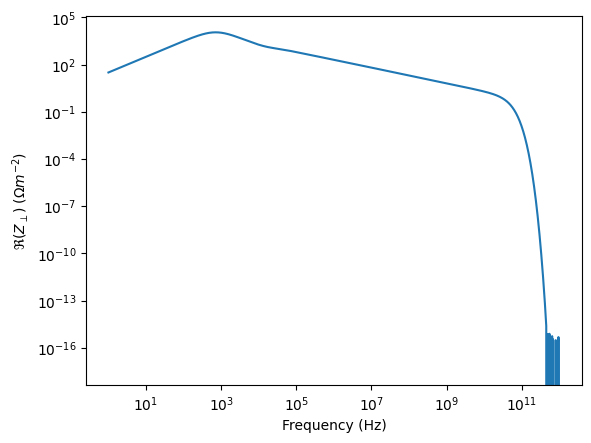

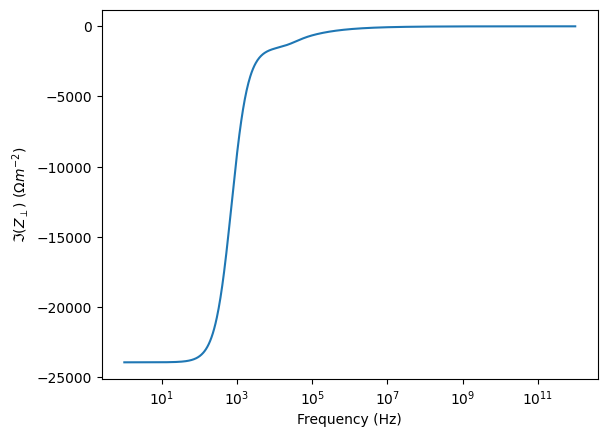

In [28]:
plt.figure()
plt.plot(freqs, np.real(results), '-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\Re \left( Z_{\perp} \right)$ ($\Omega m^{-2}$)")
plt.show()

plt.figure()
plt.plot(freqs, np.imag(results), '-')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\Im \left( Z_{\perp} \right)$ ($\Omega m^{-2}$)")
plt.show()

## Save Impedance

In [29]:
np.savetxt(os.path.join(output_path, filename + '.Z1perp.txt'),
           np.stack((freqs, np.real(results), np.imag(results)), axis=1),
           delimiter=',',
           header='Frequency (Hz), Real Zperp (Ohm/m/m), Imaginary Zperp (Ohm/m/m)')

## High and Low Frequency Approximation

In [30]:
def thinwall_vos(frequency, pipe_radius, pipe_thickness, resistivity, beta):
    L = cn.mu_0 / 2
    R = resistivity / (2 * np.pi * pipe_radius * pipe_thickness)
    ω = 2 * np.pi * frequency
    coef = -2 * cn.c / ω / pipe_radius**2
    numerator = 1j * frequency * L * R
    denominator = R - 1j * frequency * L

    return beta * coef * numerator / denominator

def thickwall_gluckstern(frequency, pipe_radius, resistivity, beta):
    permeability = cn.mu_0
    conductivity = 1 / resistivity
    ds = np.sqrt(2/((2*np.pi*frequency) * permeability * conductivity)) 
    Z_gluckstern = permeability * beta*cn.c * ds * (1-1j) / (2*np.pi*(pipe_radius)**3)
    
    return Z_gluckstern
    

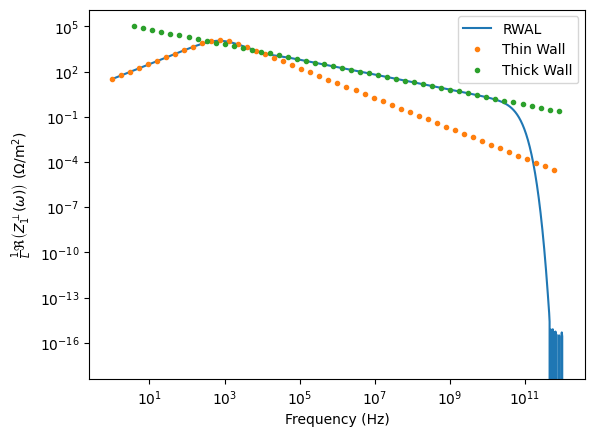

In [31]:
plt.figure()
plt.plot(freqs, np.real(results), '-', label=r'RWAL')
plt.plot(freqs[::20], np.real(thinwall_vos(freqs[::20], inner_radius,
                                               layer_thickness[0], 1/conductivity[0], 
                                              1)), '.', label='Thin Wall')
plt.plot(freqs[50::20], np.real(thickwall_gluckstern(freqs[50::20], inner_radius,
                                               1/conductivity[0], 
                                              1)), '.', label='Thick Wall')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\frac{1}{L} \Re \left( Z_{1}^{\perp}(\omega) \right)$ ($\Omega/$m$^2$)")
plt.legend(loc='upper right')
plt.show()

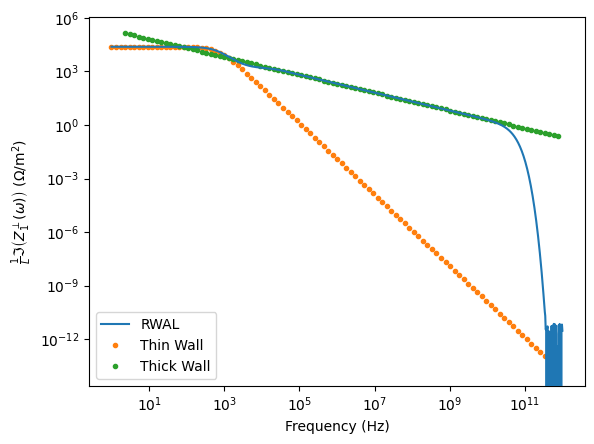

In [32]:
plt.figure()
plt.plot(freqs, -np.imag(results), '-', label=r'RWAL', zorder=10)
plt.plot(freqs[::10], -np.imag(thinwall_vos(freqs[::10], inner_radius,
                                               layer_thickness[0], 1/conductivity[0], 
                                              1)), '.', label='Thin Wall')
plt.plot(freqs[30::10], -np.imag(thickwall_gluckstern(freqs[30::10], inner_radius,
                                               1/conductivity[0], 
                                              1)), '.', label='Thick Wall')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\frac{1}{L} \Im \left( Z_{1}^{\perp}(\omega) \right)$ ($\Omega/$m$^2$)")
plt.legend(loc='lower left')
plt.show()

# Wake Function

---

**WARNING**

The wake computation of RWAL works in principle, but it is not automatically
accurate. The user has to get all the settings right and check convergence. 

---

The transverse wake, $W_{\perp}(z)$, as defined by Chao in Equation 2.72.
$$
W_{\perp}(z)
=
\frac{-i}{2\pi}
\int_{-\infty}^{\infty}
Z_{1}^{\perp}(\omega)
e^{i\omega \frac{z}{\beta c}}
\,\textrm{d}\omega
$$
Note that RWAL has until now used Gluckstern's +j sign
convention on the FT for the impedance, but I am now using Chao's formula
for the wake which uses the -i convention.

Using the symmetry properties of transverse impedances, I find that
this integral can be computed with
$$
\begin{align*}
W_{\perp}(z)
= \frac{1}{\pi} \left[
\int_{0}^{\infty} \Re \left( Z_{1}^{\perp}(\omega) \right) \sin\left(\omega \frac{z}{\beta c}\right) \,\textrm{d}\omega
+
\int_{0}^{\infty} \Im \left( Z_{1}^{\perp}(\omega) \right) \cos\left(\omega \frac{z}{\beta c}\right) \,\textrm{d}\omega
\right]
\end{align*},
$$
so that I only need to evaluate the impedance for positive frequencies,
and I can use standard Filon integrals.
To apply Filon's technique, I will truncate the integration limits at
both ends. 

## Wake Convention

I've already allowed the
user to specify the sign convention they want in the settings
and adjusted the impedance by taking the complex conjugate, so
at this point the variable "results" has the sign convention
specified by the user. If the user has specified the -i 
convention, then I can leave the impedance as it is and use
the definition above. If the user has specified the +j convention,
then I need to take the complex conjucate before I use the
wake definition here.

In [33]:
if impedance_convention == "-i":
    convention_sign = +1
else:
    convention_sign = -1

## Compute Wake

Even if I use Filon's integration method, I need some samples of the
impedance evaluated equidistantly. Since I've done a logarithmically
spaced frequency samples, I don't have an equidistant impedance samples.
To overcome this, I'm going to interpolate the impedance that's been
calculated with equidistant samples.

Filon's method will then use these and assume a polynomial fit
between them, so the samples have to be sufficiently close together for
this to be a good approximation. At the same time, I need to span
several orders of magnitude. I might need 1 Hz spacings in the
frequency range of 1-10 Hz, but if I do 1 Hz spacings centred on 1 GHz,
then I will need to do a lot of interpolations.

To overcome this problem, I will split my integral up into several
integrals and vary the equidistant spacings based on the limits.
If the lower limit is 1 GHz, then maybe I will do 1 MHz spacings etc.
I'll keep going until I hit the maximum frequency I've computed.

In [34]:
# Here I assume some behaviour of the impedance
#
# I assume that the real part of the impedance is 0 at f = 0
# I assume that the imaginary part of the impedance is equal to
# the first computed value.
# I assume that the real part is odd and the imag part even
#
# These shouldn't be bad approximations provided the frequency
# step size is sufficiently small.
_f = np.append(np.append(-freqs[::-1], 0), freqs)
_zperp_re = np.append(np.append(-np.real(results)[::-1], 0), np.real(results))
_zperp_im = np.append(np.append(+np.imag(results)[::-1], np.imag(results)[0]), np.imag(results))    

def assumed_impedance(f, length=1):
    '''
    RWAL computes the impedance for certain positive
    frequencies. This function uses the assumed impedances
    and returns an interpolated value for any frequency.
    '''
    if np.max(np.abs(f)) > freqs[-1]:
        raise ValueError("Frequency out of range.")
        return 0
    else:
        re_zperp = np.interp(f, _f, _zperp_re)
        im_zperp = np.interp(f, _f, _zperp_im)

        return (re_zperp + convention_sign * 1j*im_zperp) * length

In [35]:
# For convenience, define some vectorised versions of these
# functions so that I can evaluate the wake at several values of
# z simultaneously
filon_sin = np.vectorize(fil.filon_fun_sin,
                         excluded=(0, 1, 2, 4))
filon_cos = np.vectorize(fil.filon_fun_cos,
                         excluded=(0, 1, 2, 4))

def inverse_transform(a, b):
    '''
    Returns the inverse transform integral between the limits a and b.
    To perform an inverse Fourier transform a = 0 and b -> infty.
    '''
    F1 = filon_sin(lambda w: np.real(assumed_impedance(w / 2 / np.pi)), a, b, z / beta / cn.c, 2*mesh_setting + 1)
    F2 = filon_cos(lambda w: np.imag(assumed_impedance(w / 2 / np.pi)), a, b, z / beta / cn.c, 2*mesh_setting + 1)
    return np.real(1 / np.pi * (F1 + F2))

In [36]:
# Define the limits for the integration
# lower limits start at 0 then take every value of frequency except the last value.
# upper limit takes every value of frequency including the final value.
# multiplied by 2pi because these are limited for omega, not f
aa = np.append([0], freqs[:-1]) * 2 * np.pi
bb = freqs * 2 * np.pi

# copute the wake.
# The integral is split up into many smaller integrals with logarithmic spacing.
# Compute the integral for each limit in parallel, then add them all up.
_wake = np.array(Parallel(n_jobs=8)(delayed(inverse_transform)(i, j)
                                      for (i, j) in tqdm(zip(aa, bb), total=len(freqs))))
wake = np.sum(_wake, axis=0)
del(_wake)

100%|██████████| 1000/1000 [00:06<00:00, 163.08it/s]


## Plot Wake

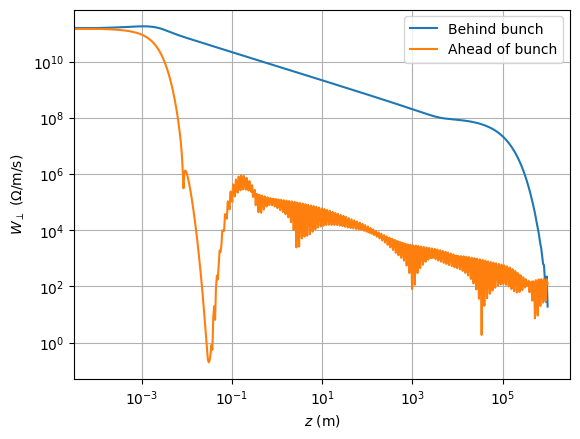

In [37]:
plt.figure()
plt.plot(-z, np.abs(wake), '-', label='Behind bunch')
plt.plot(z, np.abs(wake), '-', label='Ahead of bunch')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel(r"$z$ (m)")
plt.ylabel(r"$W_{\perp}$ ($\Omega$/m/s)") 
# plt.ylim(1e4, 5e16)
plt.legend(loc=0)
# plt.ylim(1e3, 1e12)
plt.show()

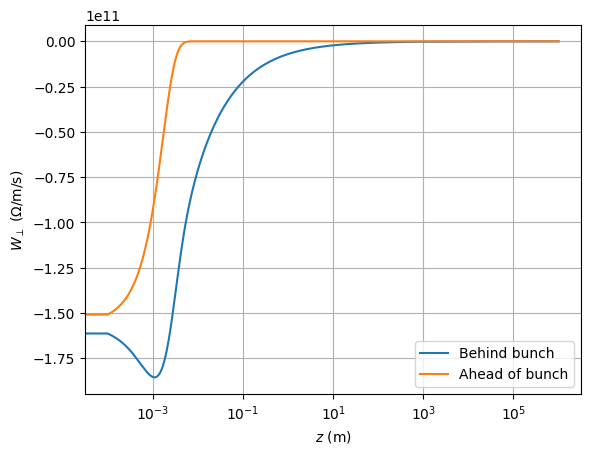

In [38]:
# Wake can go negative, so previous plot can be unclear

plt.figure()
plt.plot(-z, wake, '-', label='Behind bunch')
plt.plot(z, wake, '-', label='Ahead of bunch')
plt.xscale('log')
# plt.yscale('log')
plt.grid()
plt.xlabel(r"$z$ (m)")
plt.ylabel(r"$W_{\perp}$ ($\Omega$/m/s)") 
# plt.ylim(1e4, 5e16)
plt.legend(loc=0)
plt.show()

## Save Wake

In [39]:
np.savetxt(os.path.join(output_path, filename + '.W1perp.txt'),
           np.stack((z, wake), axis=1),
           delimiter=',',
           header='Distance ahead of source z (m), Driving W1perp (Ohm/m/s)')

## High Frequency Approximation

In [40]:
def thick_wall_wake(z, pipe_radius, conductivity, length, beta):
    heaviside = (np.sign(z)-1)/2  # = +1 if z <0, = 0 if z > 0
    z = abs(z)
    return heaviside * beta / pipe_radius**3 * np.sqrt(cn.mu_0 * beta * cn.c**3/np.pi**3/conductivity / z) * length

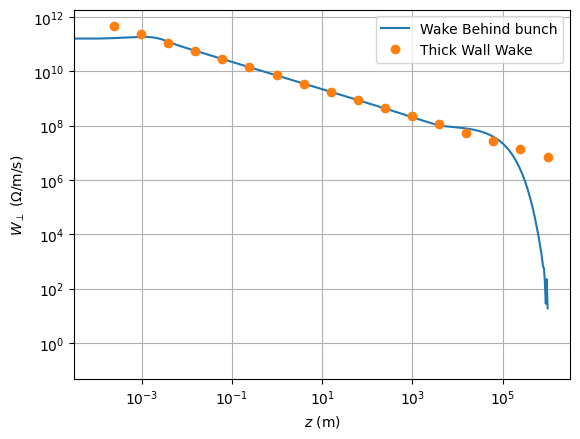

In [41]:
plt.figure()
plt.plot(-z, np.abs(wake), '-', label='Wake Behind bunch')
plt.plot(-z[::30],
         np.abs(thick_wall_wake(z, inner_radius, conductivity[0], 1, beta)[::30]), 'o',
         label='Thick Wall Wake')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel(r"$z$ (m)")
plt.ylabel(r"$W_{\perp}$ ($\Omega$/m/s)") 
# plt.ylim(1e4, 5e16)
plt.legend(loc=0)
plt.show()